In [1]:
!pip install rasterio --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [2]:
!pip install geopandas --trusted-host pypi.org --trusted-host files.pythonhosted.org


## Reading the DEM raster

In [1]:
#import richdem as rd
import rasterio
from rasterio import plot
from rasterio.enums import Resampling
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

madeenah_rio_ds = rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\eurodem.tif")
madeenah_rio_ds.profile
#print(madeenah_rio_ds.nodata)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 119862, 'height': 85809, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Arcsecond",4.84813681109536E-06],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(2.0, 0.0, -103385.85110639984,
       0.0, -2.0, 262763.8472196002), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

KeyboardInterrupt: 

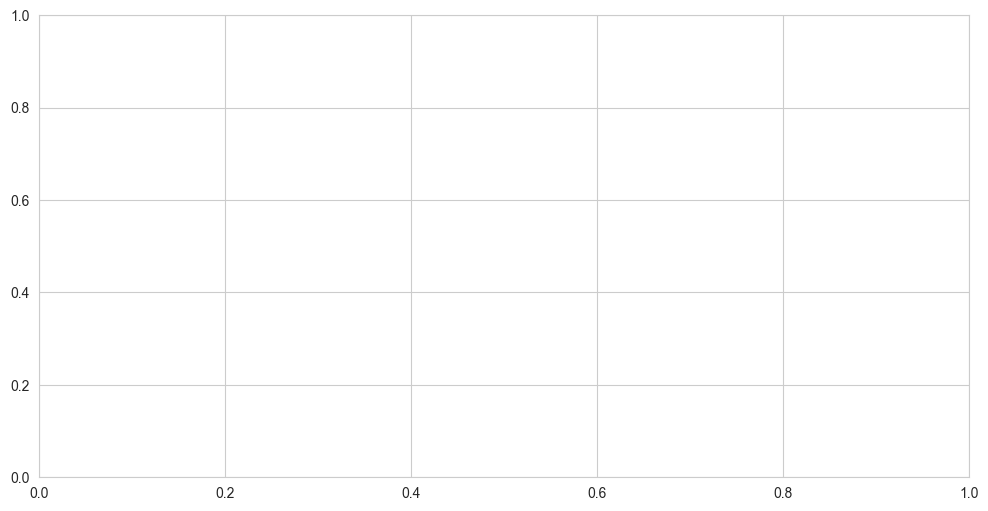

In [2]:
import rasterio
import rasterio.mask
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
im = show(madeenah_rio_ds, ax=ax, cmap='terrain')
plt.tight_layout()
plt.show()


[3 0 2 1]


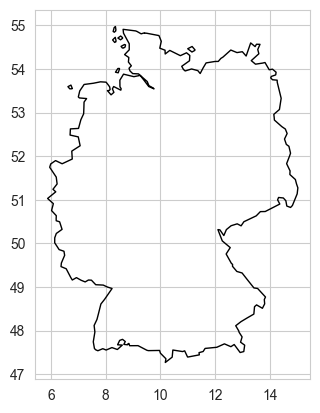

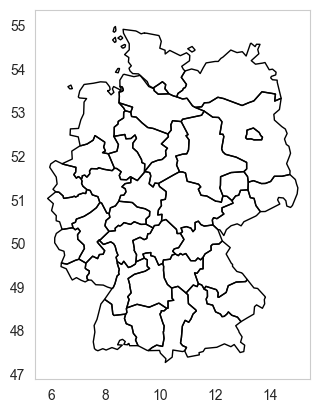

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

shpfile = r'C:\Users\mun93\Downloads\NUTS_RG_20M_2024_4326.shp\NUTS_RG_20M_2024_4326.shp'
DE_shape_file = gpd.read_file(shpfile)
print(DE_shape_file.LEVL_CODE.unique())

# Fixed the syntax error (extra parenthesis) in the following line:
DE = DE_shape_file[(DE_shape_file['NUTS_ID'].str.contains('DE')) & (DE_shape_file['LEVL_CODE'] == 0)]
DE.plot(color='none', edgecolor='black')

DE2 = DE_shape_file[(DE_shape_file['NUTS_ID'].str.contains('DE')) & (DE_shape_file['LEVL_CODE'] == 2)]
DE2.plot(color='none', edgecolor='black')

plt.grid(False)
plt.show()


In [43]:
DE.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
208,DE,0,DE,Deutschland,Deutschland,NaN,NaN,NaN,"MULTIPOLYGON (((9.1131 54.8736, 9.29561 54.808..."


In [4]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask

# Load the shapefile (ensure it has the same CRS as the raster)
shapefile = DE

# Load the raster
with rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\eurodem.tif") as src:
    # Reproject shapefile to the raster CRS (if needed)
    shapefile = shapefile.to_crs(src.crs)

    # Get the geometry of the shapefile for masking
    geometries = shapefile.geometry.values  # This gets the shape geometry

    # Mask the raster with the shapefile (ensure geometries are in list format)
    out_image, out_transform = mask(src, geometries, crop=True)
    
    # Use the NoData value instead of NaN for masking
    nodata_value = src.nodata  # Get the NoData value from the raster
    if nodata_value is not None:
        out_image[out_image == src.nodata] = nodata_value  # Set negative values (or invalid ones) as NoData 

    # Update metadata to reflect new size and transform
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the clipped raster
    with rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\DE_clipped_raster.tif", "w", **out_meta) as dest:
        dest.write(out_image)

# Now the raster has been clipped and saved


In [7]:
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
out_image.max()
# Count how many times the maximum value appears in the raster
count_max_value = (out_image == out_image.max()).sum()

print(count_max_value)

# Check the range of values in the clipped raster
min_val = np.nanmin(out_image)  # Use np.nanmin to ignore NaN values (if any)
max_val = np.nanmax(out_image)  # Use np.nanmax to ignore NaN values (if any)

print(f"Min value: {min_val}, Max value: {max_val}")


79967312
Min value: -244, Max value: 32767


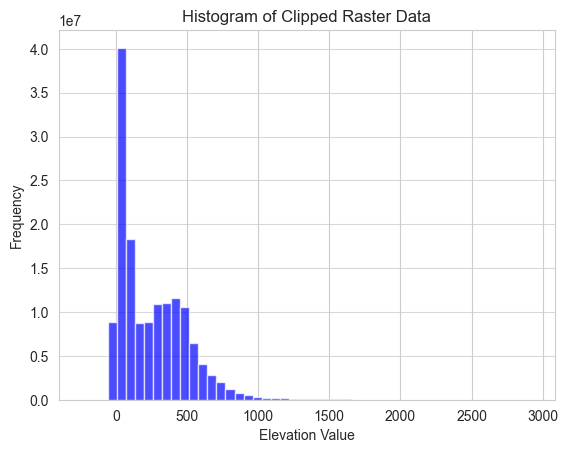

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Read the raster data
with rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\eurodem.tif") as src:
    out_image, out_transform = mask(src, DE.to_crs(src.crs).geometry, crop=True)

# Flatten the raster data to 1D
data = out_image.flatten()

# Remove NaN or NoData values (if any)
data = data[(~np.isnan(data)) & (data != src.nodata)]

# Plot the histogram using Matplotlib
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Clipped Raster Data")
plt.xlabel("Elevation Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()


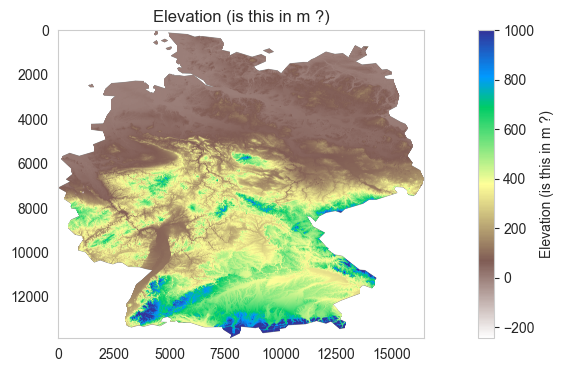

In [60]:
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

# Assuming out_image is already read (e.g., from your clipped raster)
data = out_image[0]  # Get the first band from the out_image (if it's a single-band raster)

# Get the NoData value from the raster's metadata (if available)
with rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\eurodem.tif") as src:
    nodata_value = src.nodata

# Mask NoData values by replacing them with NaN
if nodata_value is not None:
    data = np.ma.masked_equal(data, nodata_value)

# Plot the data using imshow (this returns a mappable object that can be used for colorbar)
fig, ax = plt.subplots(figsize=(14, 4))  # Optional: Set figure size
cax = ax.imshow(data, cmap='terrain_r', vmax=1000)

# Add the colorbar using the mappable object
plt.colorbar(cax, label='Elevation (is this in m ?)')

# Add title to the plot
plt.title("Elevation (is this in m ?)")
plt.tight_layout

# Display the plot
plt.grid(False)
plt.show()


C:\Users\mun93\AppData\Local\Temp\ipykernel_14612\3866641823.py:25: RuntimeWarning: invalid value encountered in sqrt
  slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))


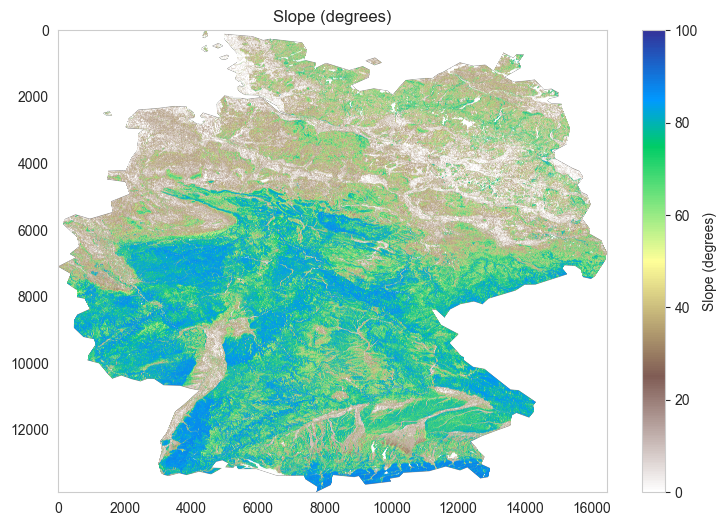

In [141]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from numpy import gradient

# Assuming out_image is already read (e.g., from your clipped raster)
data = out_image[0]  # Get the first band from the out_image (if it's a single-band raster)

# Get the NoData value from the raster's metadata (if available)
with rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\eurodem.tif") as src:
    nodata_value = src.nodata
    transform = src.transform  # To preserve spatial information

# Mask NoData values
if nodata_value is not None:
    data = np.ma.masked_equal(data, nodata_value)

# Ensure that we are handling any invalid values in the raster data
data = np.ma.masked_invalid(data)

# Calculate the gradient (slope in radians) in both x and y directions
dy, dx = gradient(data, axis=(0, 1))  # Compute gradients along x (axis=1) and y (axis=0)

# Compute the slope (in radians)
slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))

# Convert slope from radians to degrees
slope_degrees = np.degrees(slope_radians)

# Optionally: Mask NoData values in the slope result
if nodata_value is not None:
    slope_degrees = np.ma.masked_equal(slope_degrees, nodata_value)

# Plot the slope
plt.figure(figsize=(9, 6))
plt.imshow(slope_degrees, cmap='terrain_r',  vmax=100)  # Display in degrees
plt.colorbar(label='Slope (degrees)')
plt.title('Slope (degrees)')
plt.grid(False)
plt.show()

# Optionally: Save the slope raster (if needed)
out_meta = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',  # Store slope as float
    'crs': src.crs,
    'transform': transform,
    'width': data.shape[1],
    'height': data.shape[0],
    'nodata': nodata_value
}

# Save the slope as a new GeoTIFF
with rasterio.open(r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\dem_slope_output.tif", 'w', **out_meta) as dst:
    dst.write(slope_degrees.filled(nodata_value), 1)


Min slope (°): 0.00
Max slope (°): 89.74
Mean slope (°): 49.30
Median slope (°): 56.31
Std dev (°): 29.92
Total pixels: 148346591.00
NoData pixels: 80044608.00


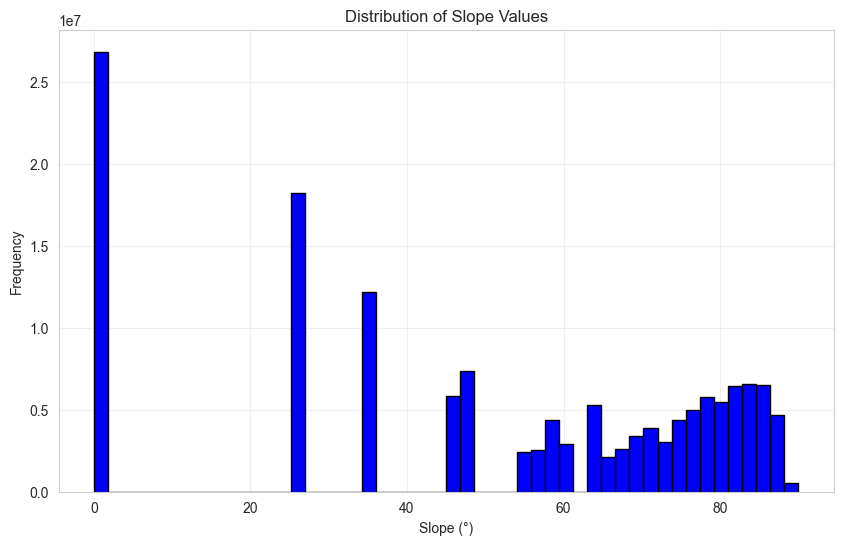

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the slope raster
slope_path = r"C:\Users\mun93\Downloads\EURO_EDM\euro-dem-tif\data\eurodem\dem_slope_output.tif"
with rasterio.open(slope_path) as src:
    slope_data = src.read(1)  # Read the first band
    slope_profile = src.profile  # Metadata (CRS, transform, etc.)
    nodata = src.nodata  # Get NoData value (if any)

# Replace NoData with NaN for analysis
if nodata is not None:
    slope_data = np.where(slope_data == nodata, np.nan, slope_data)

# Flatten the array (ignore NaNs)
valid_slopes = slope_data[~np.isnan(slope_data)]

# Compute key statistics
stats = {
    "Min slope (°)": np.min(valid_slopes),
    "Max slope (°)": np.max(valid_slopes),
    "Mean slope (°)": np.mean(valid_slopes),
    "Median slope (°)": np.median(valid_slopes),
    "Std dev (°)": np.std(valid_slopes),
    "Total pixels": len(valid_slopes),
    "NoData pixels": np.sum(np.isnan(slope_data)),
}

# Print stats
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

plt.figure(figsize=(10, 6))
plt.hist(valid_slopes, bins=50, color="blue", edgecolor="black", range=(0, 90))
plt.xlabel("Slope (°)")
plt.ylabel("Frequency")
plt.title("Distribution of Slope Values")
plt.grid(True, alpha=0.3)
plt.show()

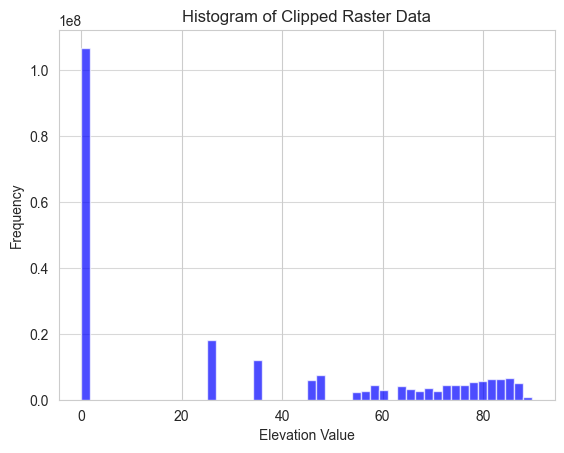

In [142]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt



# Flatten the raster data to 1D
data = slope_degrees.flatten()

# Remove NaN or NoData values (if any)
#data = data[(~np.isnan(data)) & (data != src.nodata)]

# Plot the histogram using Matplotlib
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Clipped Raster Data")
plt.xlabel("Elevation Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()


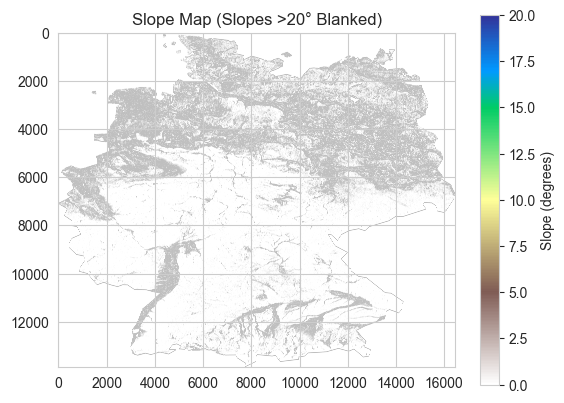

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Mask slopes >20° as NaN (transparent)
slope_masked = np.where(slope_degrees > 20, np.nan, slope_degrees)

plt.imshow(
    slope_masked,
    cmap='terrain_r',  # Color map for slopes ≤20°
    vmin=0,           # Minimum slope (0°)
    vmax=20,          # Maximum slope to display (20°)
)
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map (Slopes >20° Blanked)')
plt.show()

## Protected Area (PA)

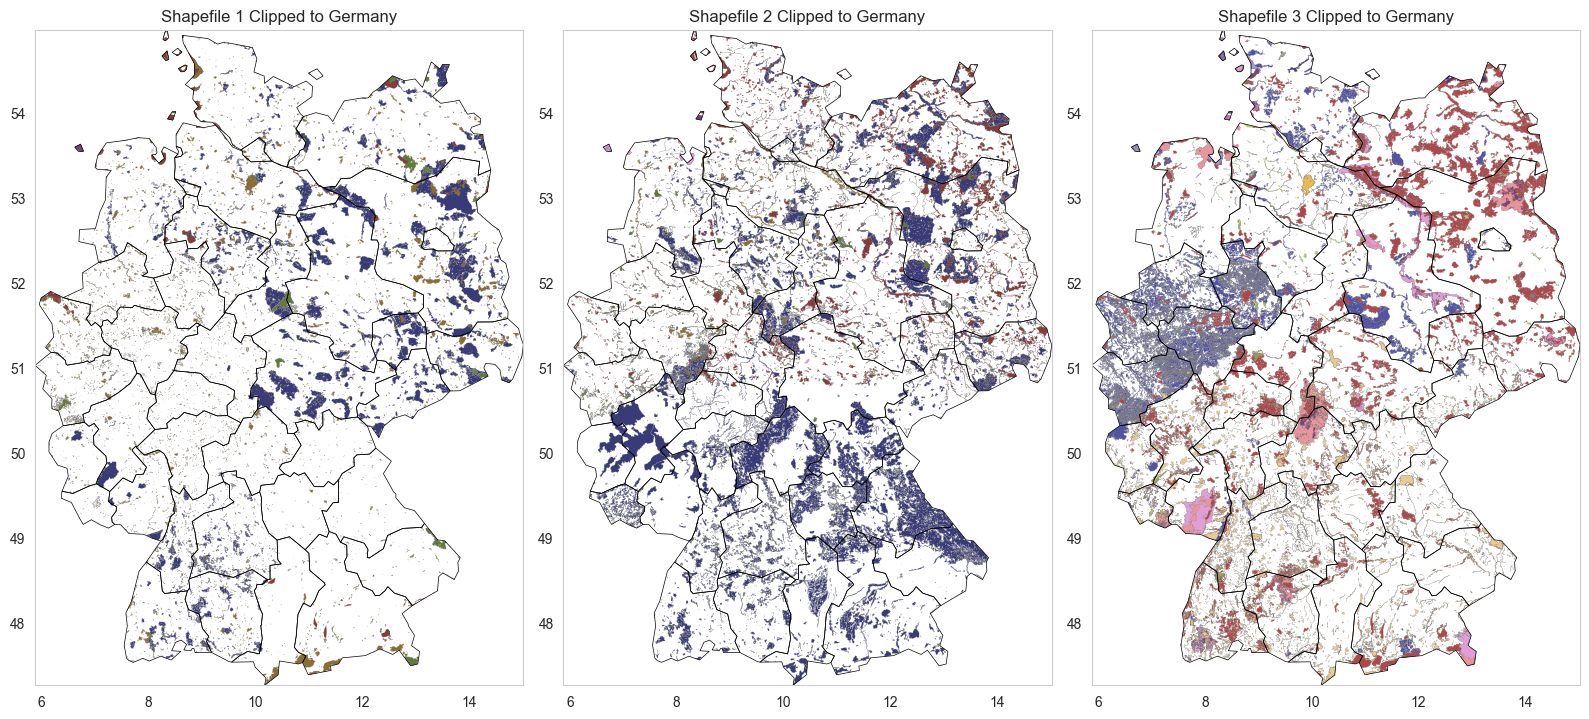

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# List of shapefile paths
shapefiles = [
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_0\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp",
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_1\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp",
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp"
]

# Load the Germany shapefile (replace with the correct path)
germany_shapefile = DE2.copy()  #<-- Replace with the actual path

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, len(shapefiles), figsize=(16, 8 * len(shapefiles)))

# Check if axes is a 1D array or 2D
if len(shapefiles) == 1:
    axes = [axes]  # If only one shapefile, axes is a single subplot

# Iterate over the shapefiles and plot them on the respective subplot
for i, shp in enumerate(shapefiles):
    # Read the shapefile
    shapefile_data = gpd.read_file(shp)

    # Clip the shapefile to the Germany boundary
    shapefile_data_clipped = gpd.clip(shapefile_data, germany_shapefile)

    # Plot the clipped shapefile on the i-th subplot
    shapefile_data_clipped.plot(column=shapefile_data_clipped.DESIG_ENG, ax=axes[i], edgecolor='grey', linewidth=0.1, cmap='tab20b' )
    # Overlay Germany borders
    germany_shapefile.boundary.plot(ax=axes[i], edgecolor='black', linewidth=0.5)
    axes[i].set_title(f"Shapefile {i+1} Clipped to Germany")
    axes[i].grid(False)

    # Set the bounds of the subplot to the Germany shapefile to ensure proper zoom
    axes[i].set_xlim(germany_shapefile.total_bounds[0], germany_shapefile.total_bounds[2])
    axes[i].set_ylim(germany_shapefile.total_bounds[1], germany_shapefile.total_bounds[3])

    

# Adjust layout for better spacing
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
#plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\mun93\AppData\Local\Temp\ipykernel_14612\1673382273.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(categories))  # or any other colormap


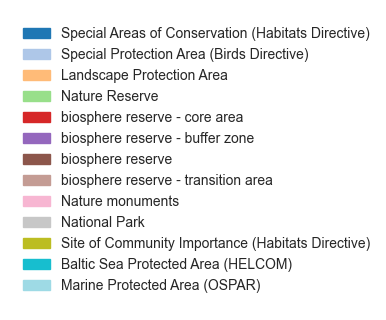

In [132]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Unique categories
categories = shapefile_data_clipped['DESIG_ENG'].unique()

# Create a colormap
cmap = cm.get_cmap('tab20', len(categories))  # or any other colormap
colors = [cmap(i) for i in range(len(categories))]

# Create legend patches
legend_patches = [mpatches.Patch(color=colors[i], label=cat) for i, cat in enumerate(categories)]

fig, ax = plt.subplots(figsize=(4, len(categories) * 0.3))  # Adjust size as needed

# Add legend
ax.legend(handles=legend_patches, loc='center left', frameon=False)
ax.axis('off')  # Hide axes
plt.show()



In [134]:
import pandas as pd
shp_test = gpd.read_file(r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp")
display(shp_test.head())
display(pd.DataFrame(shp_test.DESIG_ENG.unique()))
print(shp_test.shape)



plt.show()

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
0,555520555.0,555520555,1,Buchheller-Quellgebiet,Buchheller-Quellgebiet,Special Areas of Conservation (Habitats Direct...,Special Areas of Conservation (Habitats Direct...,Regional,Not Reported,Not Applicable,...,See European Commission Geospatial Data Catalo...,See European Commission Geospatial Data Catalo...,State Verified,1832,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.06103 50.7051, 8.06076 50.70403, 8..."
1,555520556.0,555520556,1,Orchideenwiesen bei Haiger-Seelbach,Orchideenwiesen bei Haiger-Seelbach,Special Areas of Conservation (Habitats Direct...,Special Areas of Conservation (Habitats Direct...,Regional,Not Reported,Not Applicable,...,See European Commission Geospatial Data Catalo...,See European Commission Geospatial Data Catalo...,State Verified,1832,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.18796 50.77501, 8.18798 50.77454, ..."
2,555520557.0,555520557,1,Krombachswiesen und Struth bei Sechshelden,Krombachswiesen und Struth bei Sechshelden,Special Areas of Conservation (Habitats Direct...,Special Areas of Conservation (Habitats Direct...,Regional,Not Reported,Not Applicable,...,See European Commission Geospatial Data Catalo...,See European Commission Geospatial Data Catalo...,State Verified,1832,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.23606 50.77255, 8.2372 50.77195, 8..."
3,555520558.0,555520558,1,Dill bis Herborn-Burg mit Zuflüssen,Dill bis Herborn-Burg mit Zuflüssen,Special Areas of Conservation (Habitats Direct...,Special Areas of Conservation (Habitats Direct...,Regional,Not Reported,Not Applicable,...,See European Commission Geospatial Data Catalo...,See European Commission Geospatial Data Catalo...,State Verified,1832,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.35279 50.74856, 8.35283 50.74854, ..."
4,555520559.0,555520559,1,Waldgebiet östlich von Langenaubach,Waldgebiet östlich von Langenaubach,Special Areas of Conservation (Habitats Direct...,Special Areas of Conservation (Habitats Direct...,Regional,Not Reported,Not Applicable,...,See European Commission Geospatial Data Catalo...,See European Commission Geospatial Data Catalo...,State Verified,1832,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.20562 50.72581, 8.20576 50.72521, ..."


,0
0,Special Areas of Conservation (Habitats Direct...
1,Site of Community Importance (Habitats Directive)
2,Special Protection Area (Birds Directive)
3,Baltic Sea Protected Area (HELCOM)
4,Nature Reserve
5,Landscape Protection Area
6,Marine Protected Area (OSPAR)
7,National Park
8,Nature monuments
9,biosphere reserve


(7843, 31)


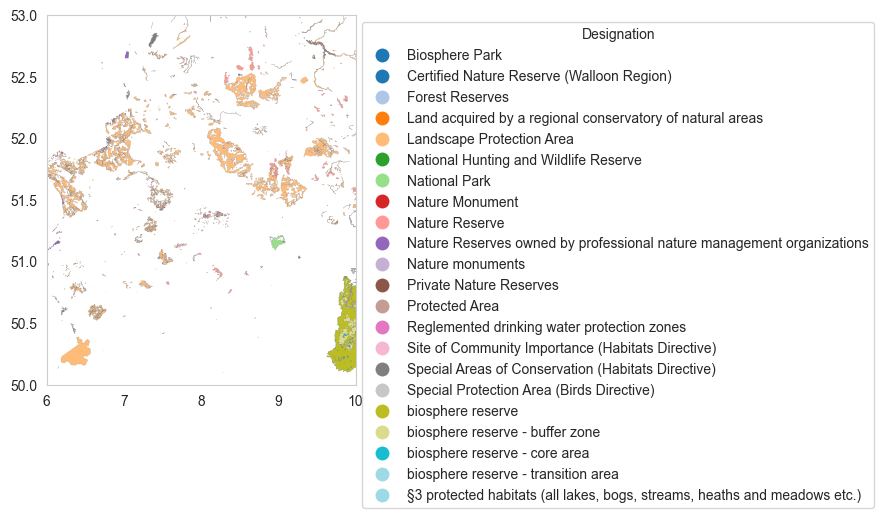

array(['Special Areas of Conservation (Habitats Directive)',
       'Biosphere Park', 'Forest Reserves', 'Private Nature Reserves',
       'biosphere reserve - core area', 'biosphere reserve - buffer zone',
       'biosphere reserve', 'biosphere reserve - transition area',
       'Landscape Protection Area', 'Nature monuments', 'Nature Reserve',
       'Site of Community Importance (Habitats Directive)',
       'Nature Monument', 'National Park',
       'Special Protection Area (Birds Directive)',
       '§3 protected habitats (all lakes, bogs, streams, heaths and meadows etc.)',
       'Land acquired by a regional conservatory of natural areas',
       'National Hunting and Wildlife Reserve',
       'Reglemented drinking water protection zones', 'Protected Area',
       'Certified Nature Reserve (Walloon Region)',
       'Nature Reserves owned by professional nature management organizations'],
      dtype=object)

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
shapefile_data_clipped[~shapefile_data_clipped.DESIG_ENG.str.contains('reserveXXX')].plot(column='DESIG_ENG', edgecolor='grey', ax=ax, linewidth=0.1, cmap='tab20',
                             legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'title': 'Designation'})

# Set the limits (replace with your desired coordinates)
ax.set_xlim([6, 10])
ax.set_ylim([50, 53])

plt.grid(False)
plt.show()


shapefile_data_clipped.DESIG_ENG.unique()

In [7]:
import geopandas as gpd

# Load protected areas shapefile
protected_areas = gpd.read_file(r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp"
                               # r"C:\Users\mun93\Downloads\merged_WDPA_polygons.shp"
                                )

# Load Germany boundary shapefile (e.g. NUTS0 or country boundary)
germany = DE.copy()

# Reproject both to a projected CRS for accurate area calculation (e.g., EPSG:3035 or EPSG:3857)
protected_areas = protected_areas.to_crs(epsg=25832)
germany = germany.to_crs(epsg=25832)

# Calculate total area of Germany (in m²)
germany_area = germany.geometry.area.sum()

# Calculate total protected area (in m²)
protected_area = protected_areas.geometry.area.sum()

# Calculate the percentage
protected_percent = (protected_area / germany_area) * 100

print(f"Protected area: {protected_area / 1e6:.2f} km²")
print(f"Germany area: {germany_area / 1e6:.2f} km²")
print(f"Protected % of Germany: {protected_percent:.2f}%")


Protected area: 180408.10 km²
Germany area: 356870.65 km²
Protected % of Germany: 50.55%


In [17]:
import geopandas as gpd
import pandas as pd

# List of your shapefiles
shapefiles = [
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_0\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp",
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_1\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp",
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp"
]

germany_shapefile = DE.copy()
# Read and combine them
gdfs = [gpd.read_file(path) for path in shapefiles]
merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
shapefile_data_clipped = gpd.clip(merged, germany_shapefile)

fig, ax = plt.subplots(figsize=(10, 10))
shapefile_data_clipped.plot(ax=ax, column='DESIG_ENG', edgecolor='grey', linewidth=0.1, cmap='tab20b')
germany_shapefile.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
plt.grid(False)
plt.show()

# Optional: Save to a new shapefile
shapefile_data_clipped["WDPAID"] = shapefile_data_clipped["WDPAID"].astype(str)
shapefile_data_clipped.to_file(r"C:\Users\mun93\Downloads\merged_WDPA_polygons.shp")

plt.grid(False)
plt.show()

<Axes: >

In [35]:
import geopandas as gpd

# Load protected areas shapefile
protected_areas = gpd.read_file(r"C:\Users\mun93\Downloads\merged_WDPA_polygons.shp")

# Load Germany boundary shapefile (e.g. NUTS0 or country boundary)
germany = DE.copy()

# Reproject both to a projected CRS for accurate area calculation (e.g., EPSG:3035 or EPSG:3857)
protected_areas = protected_areas.to_crs(epsg=3035)
germany = germany.to_crs(epsg=3035)

# Calculate total area of Germany (in m²)
germany_area = germany.geometry.area.sum()

# Calculate total protected area (in m²)
protected_area = protected_areas.geometry.area.sum()

# Calculate the percentage
protected_percent = (protected_area / germany_area) * 100

print(f"Protected area: {protected_area / 1e6:.2f} km²")
print(f"Germany area: {germany_area / 1e6:.2f} km²")
print(f"Protected % of Germany: {protected_percent:.2f}%")


Protected area: 224073.70 km²
Germany area: 356888.69 km²
Protected % of Germany: 62.79%


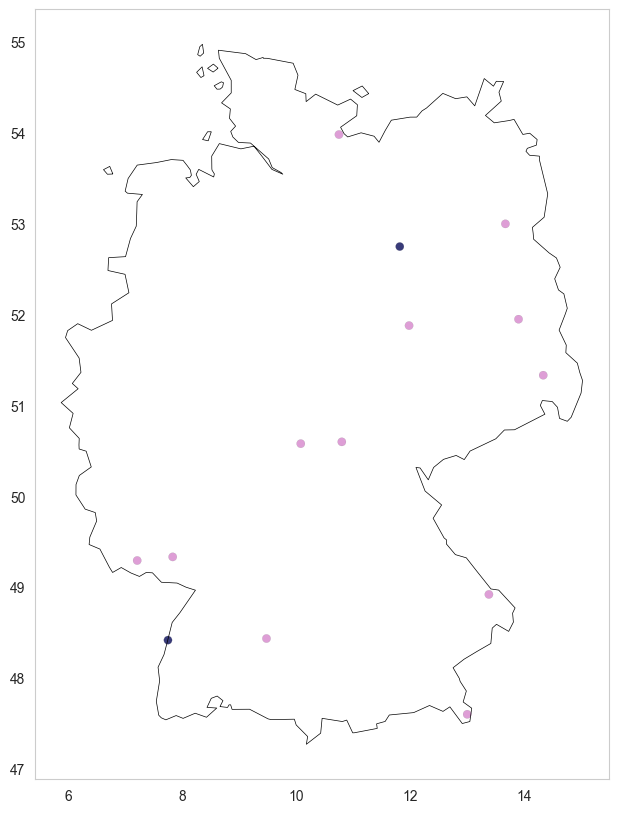

In [32]:
import geopandas as gpd
import pandas as pd

# List of your shapefiles
shapefiles = [
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_0\WDPA_WDOECM_Apr2025_Public_DEU_shp-points.shp",
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_1\WDPA_WDOECM_Apr2025_Public_DEU_shp-points.shp",
    r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-points.shp"
]

germany_shapefile = DE.copy()
# Read and combine them
gdfs = [gpd.read_file(path) for path in shapefiles]
merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
shapefile_data_clipped = gpd.clip(merged, germany_shapefile)

fig, ax = plt.subplots(figsize=(10, 10))
shapefile_data_clipped.plot(ax=ax, column='DESIG_ENG', edgecolor='grey', linewidth=0.1, cmap='tab20b')
germany_shapefile.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Optional: Save to a new shapefile
shapefile_data_clipped["WDPAID"] = shapefile_data_clipped["WDPAID"].astype(str)
shapefile_data_clipped.to_file(r"C:\Users\mun93\Downloads\merged_WDPA_points.shp")

plt.grid(False)
plt.show()

